# Humans:

Note: for this code to work, the 'data/humans' folder needs to contain one sub-folder for each performed experiment. In each of these folders, the data for the different N values must be contained.

In [43]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.special import ndtr
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, e
import json

In [ ]:
class HumanAnalysisPipeline:
    
    def __init__(self, experiment_name, analysis_type="global", log_scale_K0=False):
        self.experiment_name = experiment_name
        if analysis_type not in ["global", "subject-wise"]:
            raise ValueError("analysis_type must be either 'global' or 'subject-wise'")
        self.analysis_type = analysis_type
        self.log_scale_K0 = log_scale_K0
    
    
    def read_raw_data(self):
        print("|Reading raw data...")
        
        # Creating an empty dataframe that will be populated with all the data:
        humans_complete_raw_df = pd.DataFrame()

        # Define the path to the experiment directory:
        experiment_path = Path(f'./data/humans/{self.experiment_name}')

        if not experiment_path.exists():
            print(f"Experiment directory {experiment_path} does not exist.")
            return

        # Accessing all folders in the specified directory (each folder corresponds to a N value):
        folders = experiment_path.glob('*')
                
        for folder in folders:
            if folder.is_dir():
                print(f"||Entered folder: {folder}")
                
                # Accessing all CSV files in the specified directory:
                files = folder.glob('*.csv')
                
                for file_index, file in enumerate(files):
                    if file.is_file():                        
                        try:
                            # Reading the CSV file:
                            df = pd.read_csv(file)

                            # Concatenating the dataframes:
                            if self.analysis_type == "subject-wise":
                                if self.experiment_name == "2023-06_thesis-data":
                                    df['subject_number'] = file_index + 1   # Assigning a subject number to each file
                                else:
                                    #NOTE (to implement): assign Prolific id instead of subject number?
                                    raise ValueError("IMPLEMENT PROLIFIC ID ASSIGNMENT")
                                
                            humans_complete_raw_df = pd.concat([humans_complete_raw_df, df], axis=0, ignore_index=True)
                            
                        except Exception as e:
                            print(f"Error reading file {file}: {e}")
                            return
                    else:
                        print(f"File {file} does not exist.")
                        return
        
        self.humans_complete_raw_df = humans_complete_raw_df
        
        print(self.humans_complete_raw_df['graph_size'].unique())
        
        print("|Completed reading raw data.")
    
    
    def calculate_demographics(self):
        print("|Calculating demographics.")

        # isolating survey trials to calculate average age:
        humans_300_survey = self.humans_complete_raw_df[self.humans_complete_raw_df.trial_type == "survey-html-form"]
        # initializations:
        age = []    # list to store ages
        female_count = 0
        male_count = 0
        transgender_count = 0
        other = 0
        not_specified = 0
        # accessing ages and storing them:
        for index, row in humans_300_survey.iterrows():            
            try:
                response_dict = json.loads(row.response)
                # appending age to the list:
                age.append(int(response_dict['age']))
                # incrementing gender count:
                match response_dict['gender']:
                    case "female":
                        female_count += 1
                    case "male":
                        male_count += 1
                    case "transgender":
                        transgender_count += 1
                    case "other":
                        other += 1
                    case "not-specified":
                        not_specified += 1
                    case _:
                        return "Other"
                
            except ValueError:
                print(f"Error reading dictionary for row {index}.")                            
        
        # calculating average age and total female count:
        try:
            average_age = np.mean(age)
            print(f"Average age: {average_age}")
        except ZeroDivisionError:
            print("Error calculating average age: No valid age data found")
        
        if self.experiment_name == "2023-06_thesis-data":
            # in thesis data, same subjects performed experiment twice, so we need to divide by 2
            female_count =  female_count / 2
            male_count = male_count / 2    
        print(f"Female count: {female_count}")
        print(f"Male count: {male_count}")
        
        print("|Completed calculating demographics.")
            
     
    def clean_data(self):
        print("|Cleaning data...")
        
        try:
            # cleaning raw data to access only relevant variables:
            # - isolating experiment trials ("canvas-keyboard-response" ones) and dropping irrelevant variables:
            cleaned_df = self.humans_complete_raw_df[self.humans_complete_raw_df.trial_type == "canvas-keyboard-response"]
            # - dropping irrelevant variables:
            cleaned_df = cleaned_df.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus","graphs_couple"], axis=1).copy()
            # differentiating trials were final responses were given from shuffle trials:
            # - shuffle trials:
            self.cleaned_data_shuffles = cleaned_df[cleaned_df['response'].isin([' '])]
            # - final responses:
            self.cleaned_data_final_resp = cleaned_df[cleaned_df['response'].isin(['arrowright','arrowleft'])]
            print(self.cleaned_data_final_resp.tail())
        except Exception as e:
            print(f"Error cleaning data: {e}")
        
        print("|Completed cleaning data.")
        
        
    def calculate_fraction_correct(self):
        print("|Calculating fraction correct...")
            
        # initializations:
        df_humans_fraction_correct_appended = []
        N_values = self.cleaned_data_final_resp['graph_size'].unique()
        for N_value in N_values:
            # isolating data of current N value:
            currentN_data = self.cleaned_data_final_resp[self.cleaned_data_final_resp.graph_size == N_value]
            # isolating the single values of K:
            K_range = currentN_data['clique_size'].unique()
            for K_value in K_range:
                
                if self.analysis_type == "global":
                    # isolating data of current clique size:
                    currentK_data = currentN_data[currentN_data.clique_size == K_value]
                    # calculating accuracy for current clique size ("correct", when present, is either True or False)
                    if self.experiment_name == "2023-06_thesis-data":
                        fraction_correct_currentK = sum(currentK_data.accuracy) / sum(~ currentK_data.accuracy.isna())
                    else:
                        fraction_correct_currentK = sum(currentK_data.correct) / sum(~ currentK_data.correct.isna())
                    # appending data to the list:
                    df_humans_fraction_correct_appended.append(pd.DataFrame({'N':[N_value], 'K':[K_value], 'fc':[fraction_correct_currentK]}))
                elif self.analysis_type == "subject-wise":
                    for subject_number in currentN_data['subject_number'].unique():
                        # isolating data of current clique size and subject number:
                        currentK_data = currentN_data[(currentN_data.clique_size == K_value) & (currentN_data.subject_number == subject_number)]
                        # calculating accuracy ("correct", when present, is either True or False)
                        if self.experiment_name == "2023-06_thesis-data":
                            fraction_correct_currentK = sum(currentK_data.accuracy) / sum(~ currentK_data.accuracy.isna())
                        else:
                            fraction_correct_currentK = sum(currentK_data.correct) / sum(~ currentK_data.correct.isna())
                        # appending data to the list:
                        df_humans_fraction_correct_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K':[K_value], 'fc':[fraction_correct_currentK]}))
                else:
                    raise ValueError("Invalid analysis type")

        # creating single df for current N value:   
        df_humans_fraction_correct = pd.concat(df_humans_fraction_correct_appended)
        # creating new variable and adding it to the dataframe:
        df_humans_fraction_correct['K/sqrt(N)'] = df_humans_fraction_correct['K']/np.sqrt(df_humans_fraction_correct['N'])
        # creating new variable and adding it to the dataframe:
        df_humans_fraction_correct['K/N'] = df_humans_fraction_correct['K']/df_humans_fraction_correct['N']
        # saving dataframe:
        self.df_humans_fraction_correct = df_humans_fraction_correct
        # visualizing dataframe:
        display(df_humans_fraction_correct)  
        print("|Completed calculating fraction correct.")      
        
            
    def calculate_fitted_params(self):
        print("|Calculating fitted parameters...")
        
        def sigmoid(k, k0, delta):
            return (1+ndtr((k-k0)/delta))/2 
        
        # empty dataframe where fitted parameters will be stored:
        df_humans_fitted_params_appended = []
        
        # looping through all N values:
        for N_value in self.df_humans_fraction_correct['N'].unique():
            # selecting trials for current N value:
            current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N']==N_value]
            if self.analysis_type == "global":
                # calculating fitted parameters:
                fitted_params = curve_fit(sigmoid, current_data['K'], current_data['fc'], p0=(70, 20))[0]
                # adding fitted parameters to the dataframe (both K0, log-scaled K0 and Delta):
                df_humans_fitted_params_appended.append(pd.DataFrame({'N': [N_value], 'K0':[fitted_params[0]], 'log-K0':[np.log(fitted_params[0])], 'Delta':[fitted_params[1]]}))
            elif self.analysis_type == "subject-wise":
                # looping through all subjects for current N value:
                for subject in current_data['subject_number'].unique():
                    # accessing data for current subject:
                    current_subject_data = current_data[current_data['subject_number'] == subject]
                    # calculating fitted parameters:
                    fitted_params = curve_fit(sigmoid, current_subject_data['K'], current_subject_data['fc'], p0=(70, 20))[0]
                    # adding fitted parameters to the dataframe:
                    df_humans_fitted_params_appended.append(pd.DataFrame({'subject_number':[subject], 'N': [N_value], 'K0':[fitted_params[0]], 'log-K0':[np.log(fitted_params[0])], 'Delta':[fitted_params[1]]}))

        # concatenating dataframe of fitted parameters:
        df_humans_fitted_params = pd.concat(df_humans_fitted_params_appended)
        # saving dataframe:
        self.df_humans_fitted_params = df_humans_fitted_params
        # visualizing dataframe:
        display(df_humans_fitted_params)
        print("|Completed calculating fitted parameters.")
    
    
    def generate_psychometrics(self):
        print("|Generating psychometric curves...")
                    
        # DRAWING THE PSYCHOMETRIC CURVES
        if self.analysis_type == "global":
            fig, ax = plt.subplots(len(self.df_humans_fraction_correct['N'].unique()), 1, figsize=(2*len(self.df_humans_fraction_correct['N'].unique()), 6))
        elif self.analysis_type == "subject-wise":
            # - create subplots based on the number of N values and subjects:
            n_values = len(self.df_humans_fraction_correct['N'].unique())
            subjects = len(self.df_humans_fraction_correct['subject_number'].unique())    
            fig, ax = plt.subplots(n_values, subjects, figsize=(15, 3 * n_values))
            palette_subjects = sns.color_palette("husl", subjects)

        # - loop through the N values:
        for i, N_value in enumerate(self.df_humans_fraction_correct['N'].unique()):
            # isolating data for current N value:
            current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N'] == N_value]
            # defining x values:
            x_vals = np.linspace(0, 0.4*N_value, 1000)
            
            if self.analysis_type == "global":
                # drawing scatterplot based on fraction correct dataframe:
                sns.scatterplot(data=current_data, x='K', y='fc', ax=ax[i], s=10)
                # defining y values and plotting the psychometric curve:
                k0 = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value)]['K0'].values[0]
                delta = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value)]['Delta'].values[0]
                y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                ax[i].plot(x_vals, y_vals, color='blue', label=f'N = {N_value}')
                ax[i].set_ylabel("Fraction correct")
                ax[i].set_xlabel("Clique size")    
                ax[i].tick_params(axis='x')
                ax[i].tick_params(axis='y')
                ax[i].set_title(f"Psychometric curves for N = {int(N_value)}")
            elif self.analysis_type == "subject-wise":
                # defining y values and plotting the scatterplot and the psychometric curve:
                for j, subject_number in enumerate(current_data['subject_number'].unique()):
                    # drawing scatterplot based on fraction correct dataframe:
                    subject_data = current_data[current_data['subject_number'] == subject_number]
                    sns.scatterplot(data=subject_data, x='K', y='fc', color=palette_subjects[j], ax=ax[i, j], s=10)
                    # defining y values and plotting the psychometric curve:
                    k0 = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value) & (self.df_humans_fitted_params['subject_number'] == subject_number)]['K0'].values[0]
                    delta = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value) & (self.df_humans_fitted_params['subject_number'] == subject_number)]['Delta'].values[0]
                    y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                    ax[i, j].plot(x_vals, y_vals, color=palette_subjects[j], label=f'Subject {subject_number}')
                    ax[i, j].set_ylabel("Fraction correct")
                    ax[i, j].set_xlabel("Clique size")    
                    ax[i, j].tick_params(axis='x')
                    ax[i, j].tick_params(axis='y')
                    ax[i, j].set_title(f"N = {int(N_value)}, Subject {subject_number}")
            else:
                raise ValueError("Invalid analysis type")
              
        # saving figure in corresponding "plots" folder
        # TODO: UNCOMMENT
        # plt.savefig(f'./plots/{self.experiment_name}/humans/humans-psychometric-curves_{self.experiment_name}.svg', dpi=300, bbox_inches="tight")
        # plt.savefig(f'./plots/{self.experiment_name}/humans/humans-psychometric-curves_{self.experiment_name}.png', dpi=300, bbox_inches="tight")  
                 
        # Show the plot
        plt.tight_layout()
        plt.show()
    
    
    def calculate_shuffles(self):
        
        print("|Calculating shuffles...")
        
        # TO IMPLEMENT (adapt code below)
        
        # # looping through all N values:
        # for N_value in self.df_humans_fraction_correct['N'].unique():
        #     # selecting trials for current N value:
        #     current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N']==N_value]
        #     if self.analysis_type == "global":
        #         # calculating fitted parameters:
        #         fitted_params = curve_fit(sigmoid, current_data['K'], current_data['fc'], p0=(70, 20))[0]
        #         # adding fitted parameters to the dataframe:
        #         df_humans_fitted_params_appended.append(pd.DataFrame({'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))
        #     elif self.analysis_type == "subject-wise":
        #         # looping through all subjects for current N value:
        #         for subject in current_data['subject_number'].unique():
        #             # accessing data for current subject:
        #             current_subject_data = current_data[current_data['subject_number'] == subject]
        #             # calculating fitted parameters:
        #             fitted_params = curve_fit(sigmoid, current_subject_data['K'], current_subject_data['fc'], p0=(70, 20))[0]
        #             # adding fitted parameters to the dataframe:
        #             df_humans_fitted_params_appended.append(pd.DataFrame({'subject_number':[subject], 'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))
         
    
    # def generate_boxplot(self):
    # TODO: generate boxplot to compare the fraction of correct responses at different N values (larger N -> larger fraction correct)   
    
    def generate_main_plot(self):
                
        # Create a smaller figure with specified size
        fig, ax = plt.subplots(figsize=(8, 6))
    
        # creating palette for N values:    
        palette_global = sns.color_palette("husl", len(self.df_humans_fitted_params['N'].unique()))    
        
        # - loop through the N values:
        for i, N_value in enumerate(self.df_humans_fitted_params['N'].unique()):
            # isolating data for current N value:
            current_fitted_params = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]
            if self.analysis_type == "global":
                ax.scatter(N_value, current_fitted_params[current_fitted_params['N'] == N_value]['K0'].mean(), label=f'Humans ({N_value})', color=palette_global[i], s=120, marker="^")

            elif self.analysis_type == "subject-wise":
                palette_subjects = sns.color_palette("husl", len(current_fitted_params['subject_number'].unique()))
                ax_humans = sns.scatterplot(data=current_fitted_params, x='N', y='K0', hue='subject_number', palette=palette_subjects, legend=False, alpha=0.4, s=70, marker="^")
                ax_humans.scatter(N_value, current_fitted_params[current_fitted_params['N'] == N_value]['K0'].mean(), label=f'Humans ({N_value})', color=palette_global[i], s=120, marker="^")

        # # CHECKPOINT 2 DATA:
        # # Adding jitter to the x value (N=224) to prevent overlap:
        # jitter_strength = 15  # Adjust this value to control the jitter amount
        # for i, model in enumerate(df_checkpoint_fitted_params['model'].unique()):
        #     # Select the row for the current model
        #     model_data = df_checkpoint_fitted_params[df_checkpoint_fitted_params['model'] == model]
        #     # Add a small jitter to N=224
        #     jittered_N = np.random.normal(loc=224, scale=jitter_strength)
        #     # If model is CNN, shape it as Rudy's datapoints:
        #     if model == 'CNN':
        #         ax.scatter(jittered_N, model_data['K0'].values[0], color=my_palette_rudy[0], label=f'{model} (224)', s=60, alpha=0.8, marker='s')
        #     # Otherwise, shape it normally
        #     else:
        #         ax.scatter(jittered_N, model_data['K0'].values[0], color=my_palette_checkpoint[model], label=f'{model} (224)', s=60, alpha=0.8)

        # THEORETICAL AND COMPUTATIONAL LIMITS:
        N = np.arange(0, 1200)
        K_it = 2 * np.log2(N)
        K_comp = np.sqrt(N / e)
        my_palette_limits = ['green', 'orange']
        ax.plot(N, K_it, label='STAT limit', color=my_palette_limits[0])
        ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=my_palette_limits[1], linestyle='dotted')
        ax.plot(N[1125:], K_comp[1125:], color=my_palette_limits[1])

        # Add axes labels to the plot
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel('K₀ (clique detection threshold)', size=12)

        # # Drawing linear fit of machines' K0s with points' color gradient
        # TODO: perform linear fit on mean values of K0 for humans? In another function?
        # y_values = slope * N + intercept
        # ax.plot(N, y_values, color=my_palette_rudy[1], linestyle='--')

        # Ensure x-axis limits cover the necessary range
        ax.set_xlim(-50, max(N))
        ax.set_ylim(0, 150)

        # Customize legend:
        handles, labels = ax.get_legend_handles_labels()

        # print(handles)
        # print(labels)

        # filtered_handles = []
        # filtered_labels = []

        # # List of labels you want to keep in the legend
        # labels_to_keep = df_checkpoint_fitted_params['model'].values

        # for handle, label in zip(handles, labels):
        #     if label in labels_to_keep:
        #         filtered_handles.append(handle)
        #         filtered_labels.append(label)

        # # Add a custom legend with only the desired elements
        # ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Agents (Number of nodes):')

        # Save plot as high resolution png:
        # plt.savefig('AIHLS_figure_5.svg', dpi=300, bbox_inches="tight")

        # Set title:
        ax.set_title('Humans: K₀ as a function of N', size=14)
        plt.show()        
        
        
    def run_human_pipeline(self):
        self.read_raw_data()
        self.calculate_demographics()
        self.clean_data()
        self.calculate_fraction_correct()
        self.calculate_fitted_params()
        self.generate_psychometrics()
        # self.calculate_shuffles()        
        self.generate_main_plot()
        return self.df_humans_fitted_params

|Reading raw data...
||Entered folder: data\humans\2023-06_thesis-data\N1000
||Entered folder: data\humans\2023-06_thesis-data\N300
[  nan 1000.  300.]
|Completed reading raw data.
|Calculating demographics.
Average age: 25.733333333333334
Female count: 11.0
Male count: 4.0
|Completed calculating demographics.
|Cleaning data...
                     trial_type      rt    response  \
26825  canvas-keyboard-response   832.0   arrowleft   
26837  canvas-keyboard-response  1294.0  arrowright   
26853  canvas-keyboard-response   393.0   arrowleft   
26869  canvas-keyboard-response    67.0   arrowleft   
26877  canvas-keyboard-response   173.0  arrowright   

                                             nodes_order correct_response  \
26825  [84,142,150,268,263,26,89,97,183,33,116,193,13...        arrowleft   
26837  [255,185,72,3,191,228,175,88,242,282,172,41,12...       arrowright   
26853  [44,36,39,102,206,282,123,260,22,146,172,56,41...        arrowleft   
26869  [268,92,225,187,159,87,2

,subject_number,N,K,fc,K/sqrt(N),K/N
0,1,1000.0,300.0,1.000000,9.486833,0.300000
0,2,1000.0,300.0,1.000000,9.486833,0.300000
0,3,1000.0,300.0,1.000000,9.486833,0.300000
0,4,1000.0,300.0,0.916667,9.486833,0.300000
0,5,1000.0,300.0,1.000000,9.486833,0.300000
...,...,...,...,...,...,...
0,11,300.0,10.0,0.666667,0.577350,0.033333
0,12,300.0,10.0,0.250000,0.577350,0.033333
0,13,300.0,10.0,0.500000,0.577350,0.033333
0,14,300.0,10.0,0.333333,0.577350,0.033333


|Completed calculating fraction correct.
|Calculating fitted parameters...


,subject_number,N,K0,Delta
0,1,1000.0,101.706023,77.307746
0,2,1000.0,117.000001,2.502066
0,3,1000.0,117.594153,43.151471
0,4,1000.0,92.021640,32.990984
0,5,1000.0,96.668492,28.820746
0,6,1000.0,120.846179,40.814821
0,7,1000.0,121.833296,43.931693
0,8,1000.0,116.711473,37.706514
0,9,1000.0,98.652622,39.415463
0,10,1000.0,54.591092,100.919698


|Completed calculating fitted parameters.
|Generating psychometric curves...


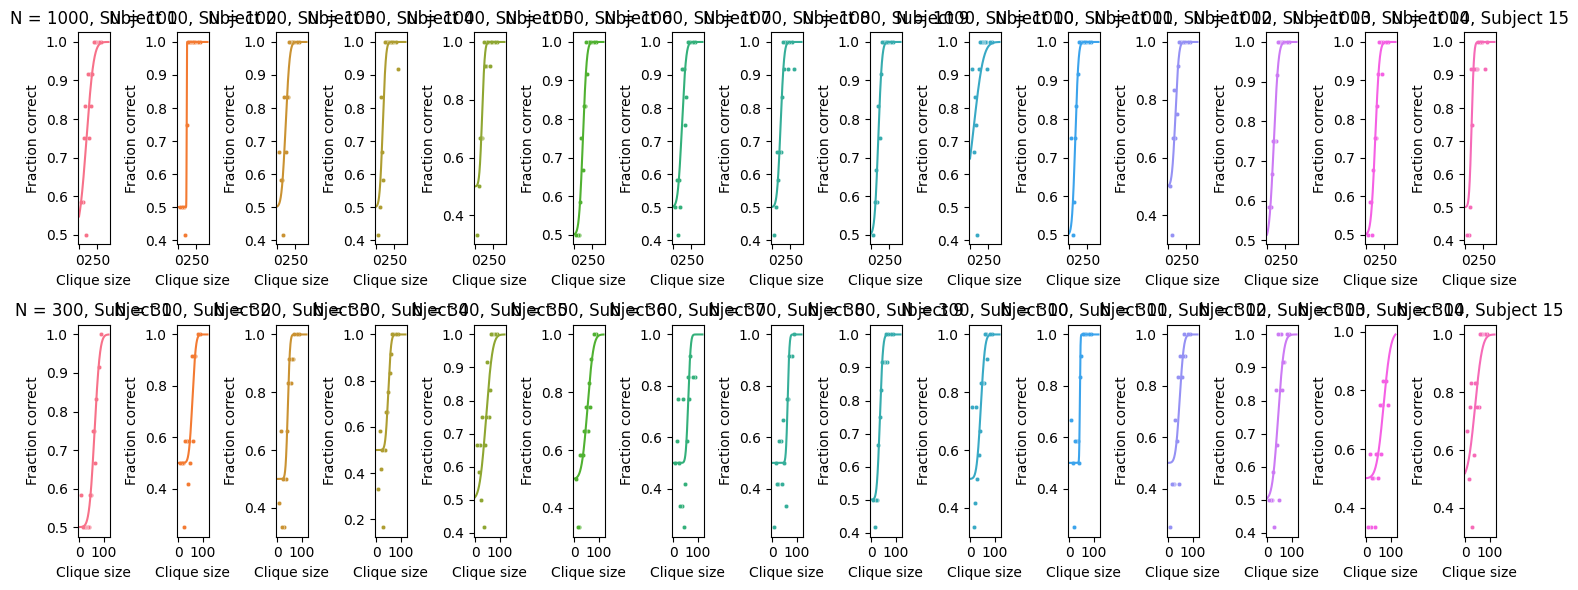

C:\Users\danie\AppData\Local\Temp\ipykernel_12804\1868486717.py:351: RuntimeWarning: divide by zero encountered in log2
  K_it = 2 * np.log2(N)


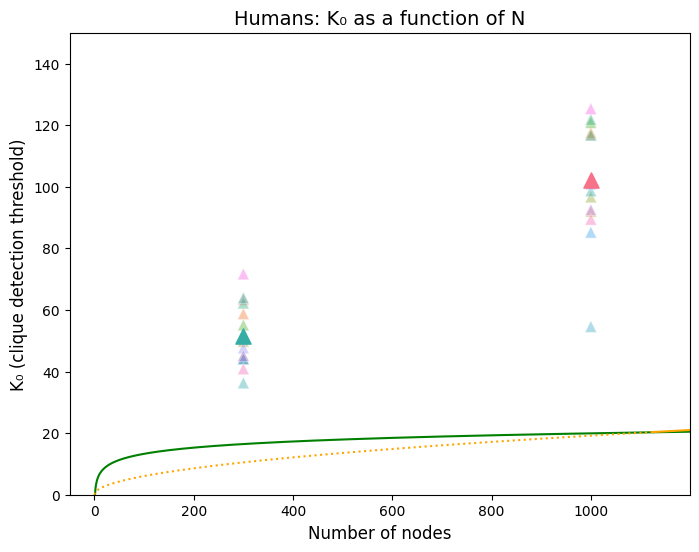

In [62]:
# Instantiate the pipeline with the experiment name
human_pipeline = HumanAnalysisPipeline(experiment_name="2023-06_thesis-data", analysis_type="subject-wise")

# Run the entire pipeline
df_humans_fitted_params = human_pipeline.run_human_pipeline()

# Machines:

Note: for this code to work, the 'data/machines' folder needs to contain one sub-folder for each full experiment at one value of N. Each of these folders needs to have the N value as name (ex. '150', '400'...) and must contain the results for the different models.

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
# from statsmodels.formula.api import ols
from scipy.special import ndtr
from scipy.optimize import curve_fit, differential_evolution
# from scipy.stats import linregress, ttest_rel, spearmanr, shapiro, sem
# from pathlib import Path
from math import sqrt
from math import log, e

import sys
import os

In [24]:
class MachinesAnalysisPipeline:

    def __init__(self, experiment_name, variance_test=False, log_scale_K0=False):
        self.experiment_name = experiment_name
        self.variance_test = variance_test
        self.log_scale_K0 = log_scale_K0
        
        #TODO: define this palette dynamically once all models are defined and training is fixed

        # Define names of all models
        model_names = ['MLP', 'ViTscratch', 'ViTpretrained', 'Variance_test', 'CNN_large', 'MLP_7layers', 'MLP_10layers', 'MLP_20layers', 'MLP_lr1e-5', 'MLP_lr1e-5_10000steps', 'MLP_li-earlystop-scatter']   # ADD MODEL NAMES HERE AND IN PALETTE BELOW
        # defining custom palette:
        machines_palette = {
            'MLP': sns.color_palette(cc.glasbey, len(model_names))[0],
            'ViTscratch': sns.color_palette(cc.glasbey, len(model_names))[1],
            'ViTpretrained': sns.color_palette(cc.glasbey, len(model_names))[2],
            'Variance_test': sns.color_palette(cc.glasbey, len(model_names))[3],
            'CNN_large': sns.color_palette(cc.glasbey, len(model_names))[4],
            'MLP_7layers': sns.color_palette(cc.glasbey, len(model_names))[5],
            'MLP_10layers': sns.color_palette(cc.glasbey, len(model_names))[6],
            'MLP_20layers': sns.color_palette(cc.glasbey, len(model_names))[7],
            'MLP_lr1e-5': sns.color_palette(cc.glasbey, len(model_names))[8],
            'MLP_lr1e-5_10000steps': sns.color_palette(cc.glasbey, len(model_names))[9],
            'MLP_li-earlystop-scatter': sns.color_palette(cc.glasbey, len(model_names))[10]
        }
        self.machines_palette = machines_palette
    
    
    def retrieve_fraction_correct(self):
        print("|Retrieving fraction correct...")
        
        # defining the path to the experiment folder:
        folder_path = os.path.join('data', 'machines', self.experiment_name)
        df_machines_fraction_correct = pd.DataFrame()
        
        # loop over all folders in the experiment folder (each folder corresponds to an N value)
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                # loop over all folders in the N folder (each folder corresponds to a model)
                for model_name in os.listdir(os.path.join(folder_path, folder_name)):
                    if os.path.isdir(os.path.join(folder_path, folder_name, model_name)):
                        file_path = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_fraction_correct.csv')
                        if os.path.isfile(file_path):
                            df_fraction_correct = pd.read_csv(file_path)
                            df_fraction_correct['model'] = model_name
                            df_fraction_correct['N'] = folder_name
                            df_machines_fraction_correct = pd.concat([df_machines_fraction_correct, df_fraction_correct], ignore_index=True)
                        else:
                            print(f"File {file_path} does not exist.")
                    else:
                        print(f"Folder {model_name} is not a directory.")
            else:
                print(f"Folder {folder_name} is not a directory.")
        
        # converting the 'N' column to integer type:
        df_machines_fraction_correct['N'] = df_machines_fraction_correct['N'].astype(int)
        self.df_machines_fraction_correct = df_machines_fraction_correct
        
        # visualizing dataframe:
        display(df_machines_fraction_correct)  
        print("|Completed retrieving fraction correct.")
         
            
    def calculate_fitted_params(self):
        print("|Calculating fitted parameters...")
        
        def sigmoid(k, k0, delta):
            return (1+ndtr((k-k0)/delta))/2 
        
        # empty dataframe where fitted parameters will be stored:
        df_machines_fitted_params_appended = []
        
        # looping through all N values:
        for N_value in self.df_machines_fraction_correct['N'].unique():
            # selecting trials for current N value:
            current_data = self.df_machines_fraction_correct[self.df_machines_fraction_correct['N']==N_value]
            # looping through all models for current N value:
            for model in current_data['model'].unique():
                # accessing data for current subject:
                current_model_data = current_data[current_data['model'] == model]
                # calculating fitted parameters:
                fitted_params = curve_fit(sigmoid, current_model_data['clique size'], current_model_data['fraction correct'], p0=(70, 20))[0]
                # adding fitted parameters to the dataframe (including log-scaled K0):
                df_machines_fitted_params_appended.append(pd.DataFrame({'model':[model], 'N': [N_value], 'K0':[fitted_params[0]], 'log_K0':[np.log(fitted_params[0])], 'Delta':[fitted_params[1]]}))                

            if self.variance_test:
                # adding K0 value of the Variance test to the dataframe:
                folder_path = os.path.join('data', 'machines', self.experiment_name)
                file_path = os.path.join(folder_path, f'{N_value}', 'Variance_test', f'Variance_test_N{N_value}_K0.csv')
                print(file_path)
                if os.path.isfile(file_path):
                    df_K0_variance_test = pd.read_csv(file_path)
                    df_machines_fitted_params_appended.append(pd.DataFrame({'model':['Variance_test'], 'N': [N_value], 'K0':[df_K0_variance_test['K0'][0]], 'log_K0':[np.log(df_K0_variance_test['K0'][0])], 'Delta':"Not Available"}))
                
        # concatenating dataframe of fitted parameters:
        df_machines_fitted_params = pd.concat(df_machines_fitted_params_appended)
        # saving dataframe:
        self.df_machines_fitted_params = df_machines_fitted_params
        
        # visualizing dataframe:
        display(df_machines_fitted_params)
        print("|Completed calculating fitted parameters.")

        
    def metrics_summary(self):
        print("|Generating metrics summary...")
            
        # defining the path to the experiment folder:
        folder_path = os.path.join('data', 'machines', self.experiment_name)
        metrics_summary_df = pd.DataFrame()
        
        # loop over all folders in the experiment folder (each folder corresponds to an N value)
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                # loop over all folders in the N folder (each folder corresponds to a model)
                for model_name in os.listdir(os.path.join(folder_path, folder_name)):
                    if os.path.isdir(os.path.join(folder_path, folder_name, model_name)):
                        file_path = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_metrics.csv')
                        if os.path.isfile(file_path):
                            df_metrics_model = pd.read_csv(file_path)
                            df_metrics_model['N'] = folder_name
                            df_metrics_model['model'] = model_name
                            # adding K0 value to the dataframe:
                            # - normal K0 value:
                            df_metrics_model['K0'] = self.df_machines_fitted_params.loc[(self.df_machines_fitted_params['N'] == int(folder_name)) & (self.df_machines_fitted_params['model'] == model_name), 'K0'].values[0]
                            # - log-scaled K0 value:
                            df_metrics_model['log_K0'] = self.df_machines_fitted_params.loc[(self.df_machines_fitted_params['N'] == int(folder_name)) & (self.df_machines_fitted_params['model'] == model_name), 'log_K0'].values[0]
                            metrics_summary_df = pd.concat([metrics_summary_df, df_metrics_model], ignore_index=True)
                        else:
                            print(f"File {file_path} does not exist.")
                    else:
                        print(f"Folder {folder_name} is not a directory.")
                            
        # write k0 column in decimal notation:
        metrics_summary_df['K0'] = metrics_summary_df['K0'].apply(lambda x: '{:.2f}'.format(x))
        metrics_summary_df['log_K0'] = metrics_summary_df['log_K0'].apply(lambda x: '{:.2f}'.format(x))
        # rounding all values to 2 decimal places:
        metrics_summary_df = metrics_summary_df.round(2)
        # place the 'model', 'N', 'K0' and 'log_K0' columns at the beginning of the dataframe:
        cols = ['model', 'N', 'K0', 'log_K0'] + [col for col in metrics_summary_df.columns if col not in ['model', 'N', 'K0', 'log_K0']]
        metrics_summary_df = metrics_summary_df[cols]

        display(metrics_summary_df)
        self.metrics_summary_df = metrics_summary_df
        print("|Completed generating metrics summary.")
        
        
    def generate_psychometrics(self):
        print("|Generating psychometric curves...")

        # Get the unique values as an iterable array of integers
        unique_n_values = self.df_machines_fraction_correct['N'].unique()
        unique_n_values = np.sort(unique_n_values)

        # - create subplots based on the number of N values:
        n_values = len(unique_n_values)
        if n_values == 9:
            rows = 3
            cols = 3
        else: 
            raise ValueError(f"The number of N values should be 9, but is {n_values}. Check for errors in the code.")
        fig, ax = plt.subplots(rows, cols, figsize=(20, 15))

        # Ensure ax is always a 2D array for consistency
        ax = ax.flatten()

        # - loop through the N values:
        for i, N_value in enumerate(unique_n_values):
            # isolating data for current N value:
            current_data = self.df_machines_fraction_correct[self.df_machines_fraction_correct['N'] == N_value]
            # filtering the data to include only the models for which k0 is smaller than N:
            current_data = current_data[current_data['clique size'] < int(N_value)]
            # getting the names of the models to filter the palette:
            models_names = current_data['model'].unique()
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in models_names}
            # defining x values:
            x_vals = np.linspace(0, 0.7 * int(N_value), 1000)

            # drawing scatterplot based on fraction correct dataframe:
            sns.scatterplot(data=current_data, x='clique size', y='fraction correct', ax=ax[i], s=10, hue='model', palette=machines_palette_filtered)
            # defining y values and plotting the psychometric curve:
            for model in models_names:
                k0 = self.df_machines_fitted_params[(self.df_machines_fitted_params['N'] == N_value) & (self.df_machines_fitted_params['model'] == model)]['K0'].values[0]
                delta = self.df_machines_fitted_params[(self.df_machines_fitted_params['N'] == N_value) & (self.df_machines_fitted_params['model'] == model)]['Delta'].values[0]
                y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                ax[i].plot(x_vals, y_vals, color=machines_palette_filtered[model], label=model)

            # setting labels and title for the subplot:
            ax[i].set_ylabel("Fraction correct")
            ax[i].set_xlabel("Clique size")
            ax[i].set_title(f"Psychometric curves for N = {int(N_value)}")
            ax[i].tick_params(axis='x')
            ax[i].tick_params(axis='y')
            ax[i].set_title(f"Best models in {self.experiment_name} for N = {int(N_value)}")

        # Hide any unused subplots
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])

        # Show the plot
        plt.tight_layout()
        
        # Save plot as high resolution svg:
        if self.variance_test:
            # - With variance test   
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}_Variance-test.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}_Variance-test.png', dpi=300, bbox_inches="tight")        
        else:
            # - Without variance test
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}.png', dpi=300, bbox_inches="tight")  
                        
        plt.show()
        
        print("|Completed generating psychometric curves.")
    

    def generate_k0_plots(self):
        print("|Generating K0 plot...")
        
        # Get the unique values as an iterable array of integers
        unique_n_values = self.df_machines_fraction_correct['N'].unique()
        unique_n_values = np.sort(unique_n_values)

        # - create subplots based on the number of N values:
        n_values = len(unique_n_values)
        if n_values == 9:
            rows = 3
            cols = 3
        else: 
            raise ValueError(f"The number of N values should be 9, but is {n_values}. Check for errors in the code.")
        fig, ax = plt.subplots(rows, cols, figsize=(16, 15))

        # Ensure ax is always a 2D array for consistency
        ax = ax.flatten()
        
        # - loop through the N values:
        for i, N_value in enumerate(unique_n_values):
            # isolating data for current N value:
            current_fitted_params = self.df_machines_fitted_params[self.df_machines_fitted_params['N'] == N_value]
            # filtering the data to keep only the models for which K0 is smaller than N:
            current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in current_fitted_params['model'].unique()}
            # drawing swarmplot based on fraction correct dataframe:
            
            sns.swarmplot(data=current_fitted_params, x='N', y='log_K0' if self.log_scale_K0 else 'K0', hue='model', palette=machines_palette_filtered, ax=ax[i], s=7)
        
            # Draw the statistical limit line
            ax[i].axhline(y=np.log(2*np.log2(int(N_value))) if self.log_scale_K0 else 2*np.log2(int(N_value)), color='g', linestyle=':')

            # Adjust legend to include the statistical limit line
            handles, labels = ax[i].get_legend_handles_labels()
            # Append the statistical limit line handle and label
            handles.append(plt.Line2D([], [], color='g', linestyle=':', label='STAT limit'))
            labels.append('STAT limit')
            ax[i].legend(handles=handles, labels=labels)
        
            # Add axes labels to the plot
            ax[i].set_xlabel('Number of nodes', size=12)
            ax[i].set_ylabel('K₀ (log-scaled)' if self.log_scale_K0 else 'K₀', size=12)
            ax[i].set_title(f'Machines: K₀ {"(log-scaled)" if self.log_scale_K0 else ""} as a function of N = {int(N_value)}', size=14)        
        
        # Hide any unused subplots
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])

        # Show the plot
        plt.tight_layout()
        
        # Save plot as high resolution svg:
        if self.variance_test:
            # - With variance test   
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}_Variance-test{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}_Variance-test{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")        
        else:
            # - Without variance test
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")  
        
        plt.show()
        
        print("|Completed generating K0 plot.")
    

    def generate_main_plot(self):
        print("|Generating main plot...")
        
        # Create a smaller figure with specified size
        fig, ax = plt.subplots(figsize=(8, 6))   
        
        # Loop through the N values:
        for i, N_value in enumerate(self.df_machines_fitted_params['N'].unique()):
            # Isolating data for the current N value:
            current_fitted_params = self.df_machines_fitted_params[self.df_machines_fitted_params['N'] == N_value]
             
            # Filtering the data to keep only the models for which K0 is smaller than N:
            current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in current_fitted_params['model'].unique()}
            
            # Add a small jitter to the N column to avoid overlap
            jittered_x = current_fitted_params['N'] + np.random.uniform(-10, 10, size=len(current_fitted_params))

            # Draw scatterplot with jittered x values (only drawing one legend)
            sns.scatterplot(data=current_fitted_params, x=jittered_x, y='log_K0' if self.log_scale_K0 else 'K0', hue='model', 
                            palette=machines_palette_filtered, legend=(N_value == 400), s=50, ax=ax)    # Only draw legend for N=400 (contains MLP variants)

        # THEORETICAL AND COMPUTATIONAL LIMITS:
        N = np.arange(0.1, 1200)
        if self.log_scale_K0:    
            K_it = np.log(2 * np.log2(N))
            K_comp = np.log(np.sqrt(N / np.e))
        else:
            K_it = 2 * np.log2(N)
            K_comp = np.sqrt(N / np.e)            
        limits_palette = ['green', 'orange']
        ax.plot(N, K_it, label='STAT limit', color=limits_palette[0])
        ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
        ax.plot(N[1125:], K_comp[1125:], color=limits_palette[1])
        
        # Add axes labels to the plot
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel(f'{"Log-scaled " if self.log_scale_K0 else ""}K₀ (clique detection threshold)', size=12)

        # Automatically adjust the x-axis and y-axis limits to fit the data
        ax.autoscale()        

        # Customize legend:
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        
        # Set title:
        ax.set_title('Machines: K₀ as a function of N', size=14)
                
        # Save plot as high resolution svg:
        if self.variance_test:
            # - With variance test   
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}_Variance-test{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}_Variance-test{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")        
        else:
            # - Without variance test
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")  
        
        plt.show()
        
        print("|Completed generating main plot.")

  
    def fitted_params_machines(self):
        self.retrieve_fraction_correct()
        self.calculate_fitted_params()
        return self.df_machines_fitted_params, self.machines_palette    
  
    def complete_machines_pipeline(self):
        self.retrieve_fraction_correct()
        self.calculate_fitted_params()
        self.metrics_summary()
        self.generate_psychometrics()
        self.generate_k0_plots()
        self.generate_main_plot() 

|Retrieving fraction correct...
File data\machines\2025-02-26_li-earlystop-scatter\100\Variance_test\Variance_test_N100_fraction_correct.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\1200\Variance_test\Variance_test_N1200_fraction_correct.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\150\Variance_test\Variance_test_N150_fraction_correct.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\200\Variance_test\Variance_test_N200_fraction_correct.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\300\Variance_test\Variance_test_N300_fraction_correct.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\400\Variance_test\Variance_test_N400_fraction_correct.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\480\Variance_test\Variance_test_N480_fraction_correct.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\600\Variance_test\Variance_test_N600_fra

,clique size,fraction correct,model,N
0,70,0.99,CNN_large,100
1,69,0.99,CNN_large,100
2,68,0.99,CNN_large,100
3,67,0.99,CNN_large,100
4,66,0.98,CNN_large,100
...,...,...,...,...
3675,23,0.49,ViTscratch,800
3676,17,0.49,ViTscratch,800
3677,12,0.50,ViTscratch,800
3678,6,0.51,ViTscratch,800


|Completed retrieving fraction correct.
|Calculating fitted parameters...


C:\Users\danie\AppData\Local\Temp\ipykernel_18976\1320486201.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  fitted_params = curve_fit(sigmoid, current_model_data['clique size'], current_model_data['fraction correct'], p0=(70, 20))[0]


,model,N,K0,log_K0,Delta
0,CNN_large,100,1.845103e+01,2.915120,3.978695e+00
0,MLP,100,2.568927e+01,3.246073,5.240386e+00
0,ViTpretrained,100,2.070365e+01,3.030310,6.984122e+00
0,ViTscratch,100,2.554924e+01,3.240608,6.502993e+00
0,CNN_large,1200,1.677221e+02,5.122308,2.954822e+01
0,MLP,1200,3.102681e+02,5.737437,6.208548e+01
0,ViTpretrained,1200,1.997479e+02,5.297056,5.889966e+01
0,ViTscratch,1200,1.898838e+02,5.246412,3.368262e+01
0,CNN_large,150,2.430369e+01,3.190628,4.969536e+00
0,MLP,150,3.859321e+01,3.653076,7.498055e+00


|Completed calculating fitted parameters.
|Generating metrics summary...
File data\machines\2025-02-26_li-earlystop-scatter\100\Variance_test\Variance_test_N100_metrics.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\1200\Variance_test\Variance_test_N1200_metrics.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\150\Variance_test\Variance_test_N150_metrics.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\200\Variance_test\Variance_test_N200_metrics.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\300\Variance_test\Variance_test_N300_metrics.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\400\Variance_test\Variance_test_N400_metrics.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\480\Variance_test\Variance_test_N480_metrics.csv does not exist.
File data\machines\2025-02-26_li-earlystop-scatter\600\Variance_test\Variance_test_N600_metrics.csv does not exis

,model,N,K0,log_K0,TP,FP,TN,FN,precision,recall,F1,AUC_ROC,total_params
0,CNN_large,100,18.45,2.92,13572,398,17519,4351,0.97,0.76,0.85,0.90,NaN
1,MLP,100,25.69,3.25,11790,444,17451,6155,0.96,0.66,0.78,0.87,NaN
2,ViTpretrained,100,20.70,3.03,13815,2384,15551,4090,0.85,0.77,0.81,0.87,NaN
3,ViTscratch,100,25.55,3.24,12211,1259,16683,5687,0.91,0.68,0.78,0.85,NaN
4,CNN_large,1200,167.72,5.12,20550,65,25497,5088,1.00,0.80,0.89,0.93,445065761.0
5,MLP,1200,310.27,5.74,16103,137,25606,9354,0.99,0.63,0.77,0.87,NaN
6,ViTpretrained,1200,199.75,5.30,19968,1875,23989,5368,0.91,0.79,0.85,0.90,NaN
7,ViTscratch,1200,189.88,5.25,19894,199,25259,5848,0.99,0.77,0.87,0.92,NaN
8,CNN_large,150,24.30,3.19,18086,637,24976,7501,0.97,0.71,0.82,0.87,445065761.0
9,MLP,150,38.59,3.65,16280,415,25302,9203,0.98,0.64,0.77,0.86,NaN


|Completed generating metrics summary.
|Generating psychometric curves...


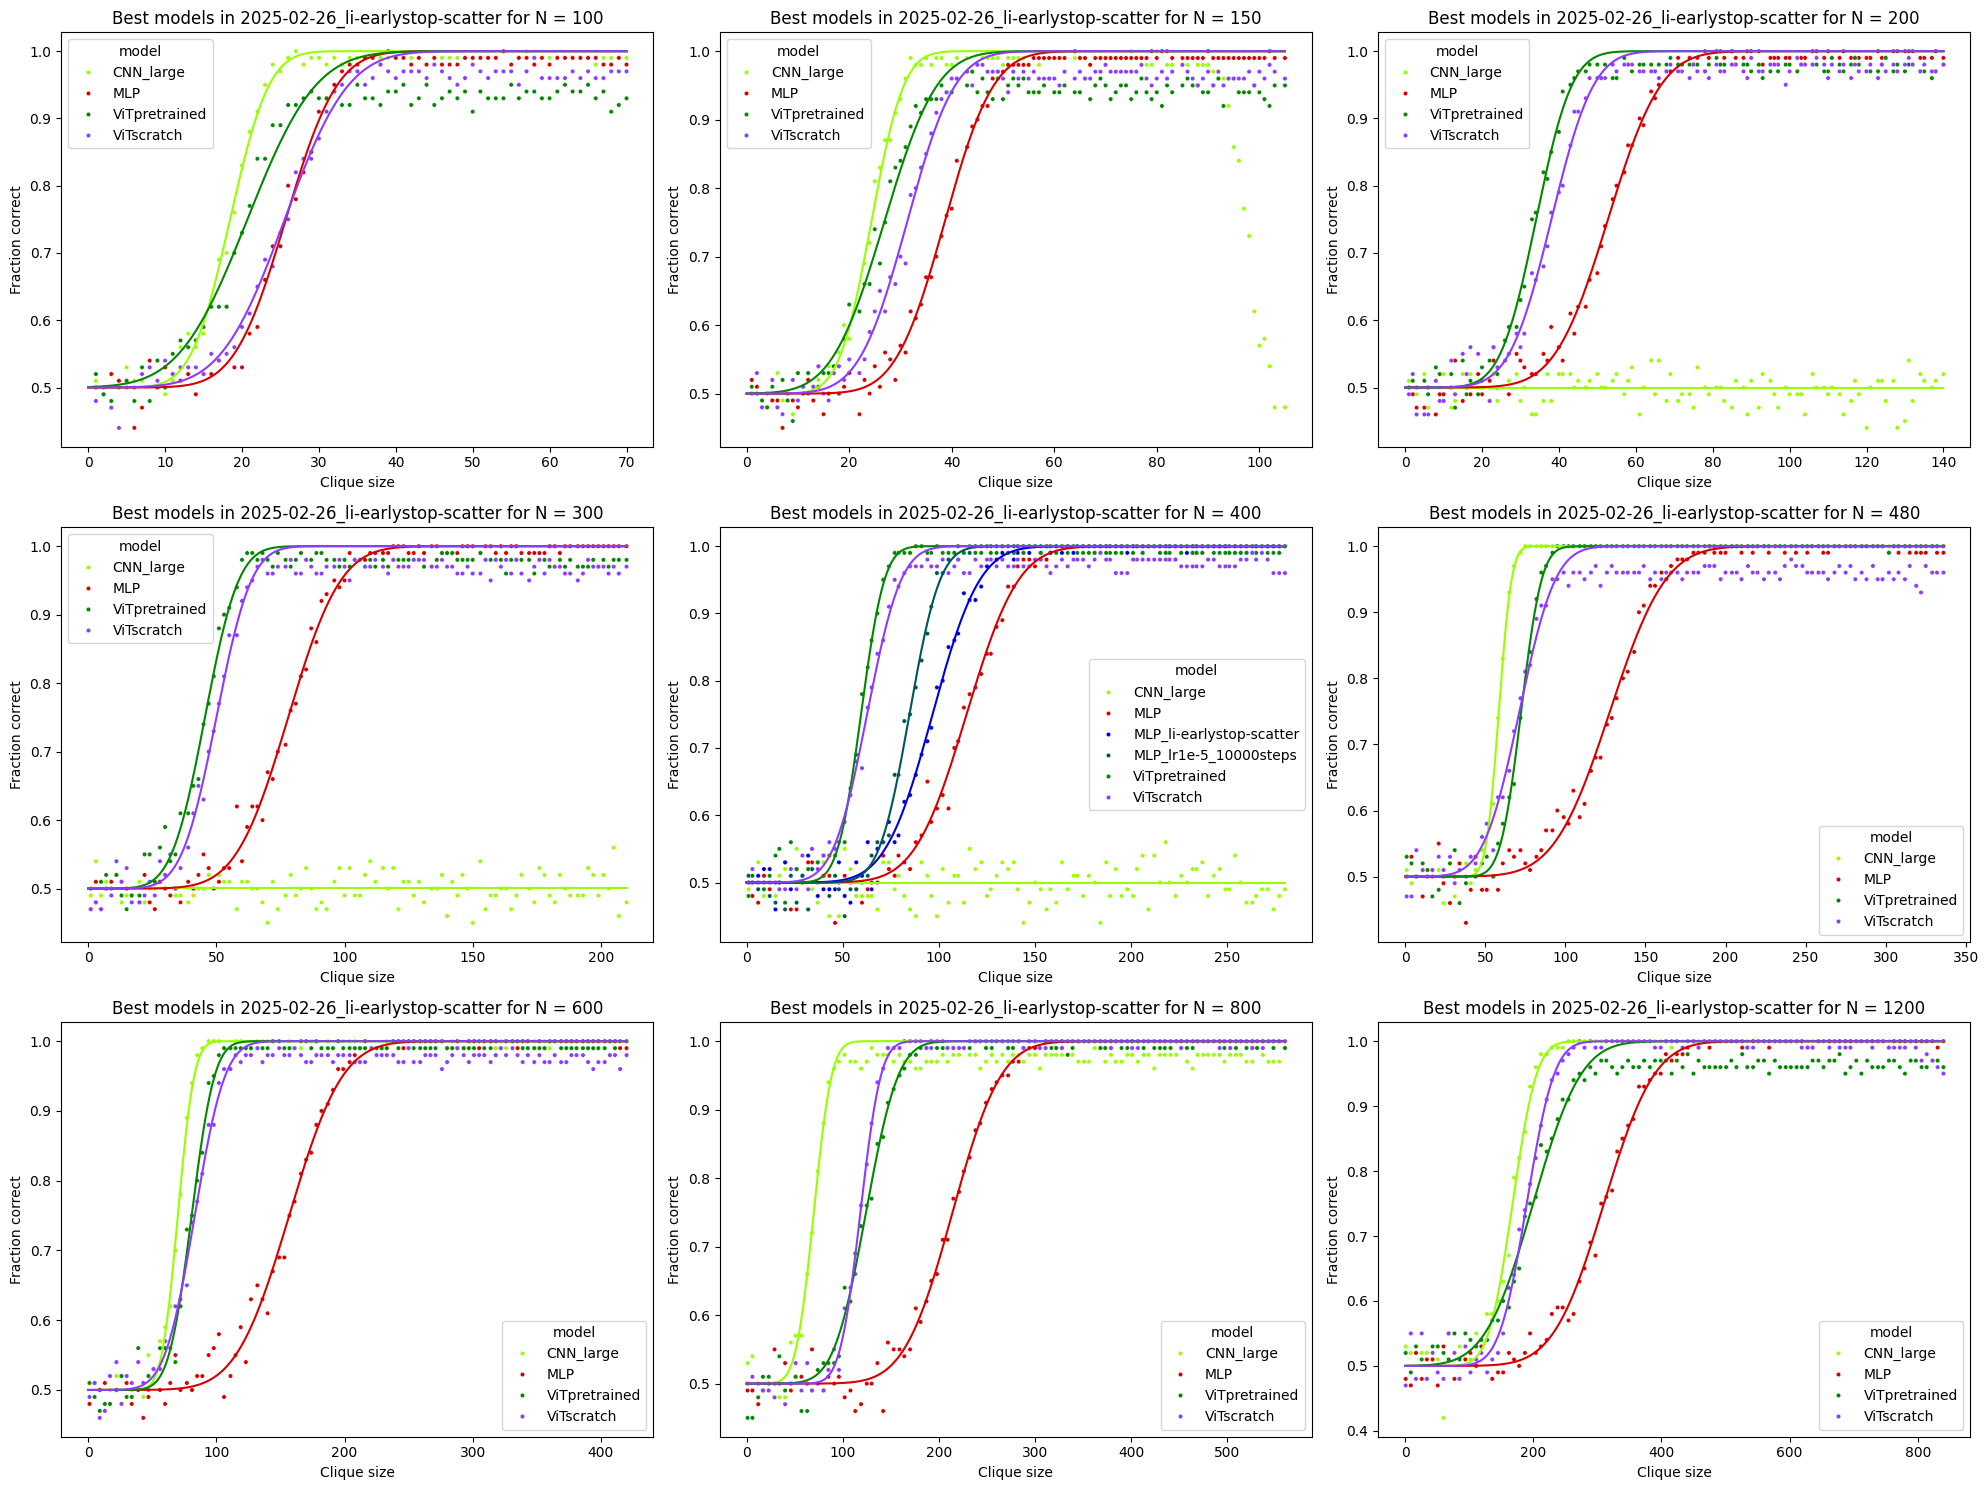

|Completed generating psychometric curves.
|Generating K0 plot...


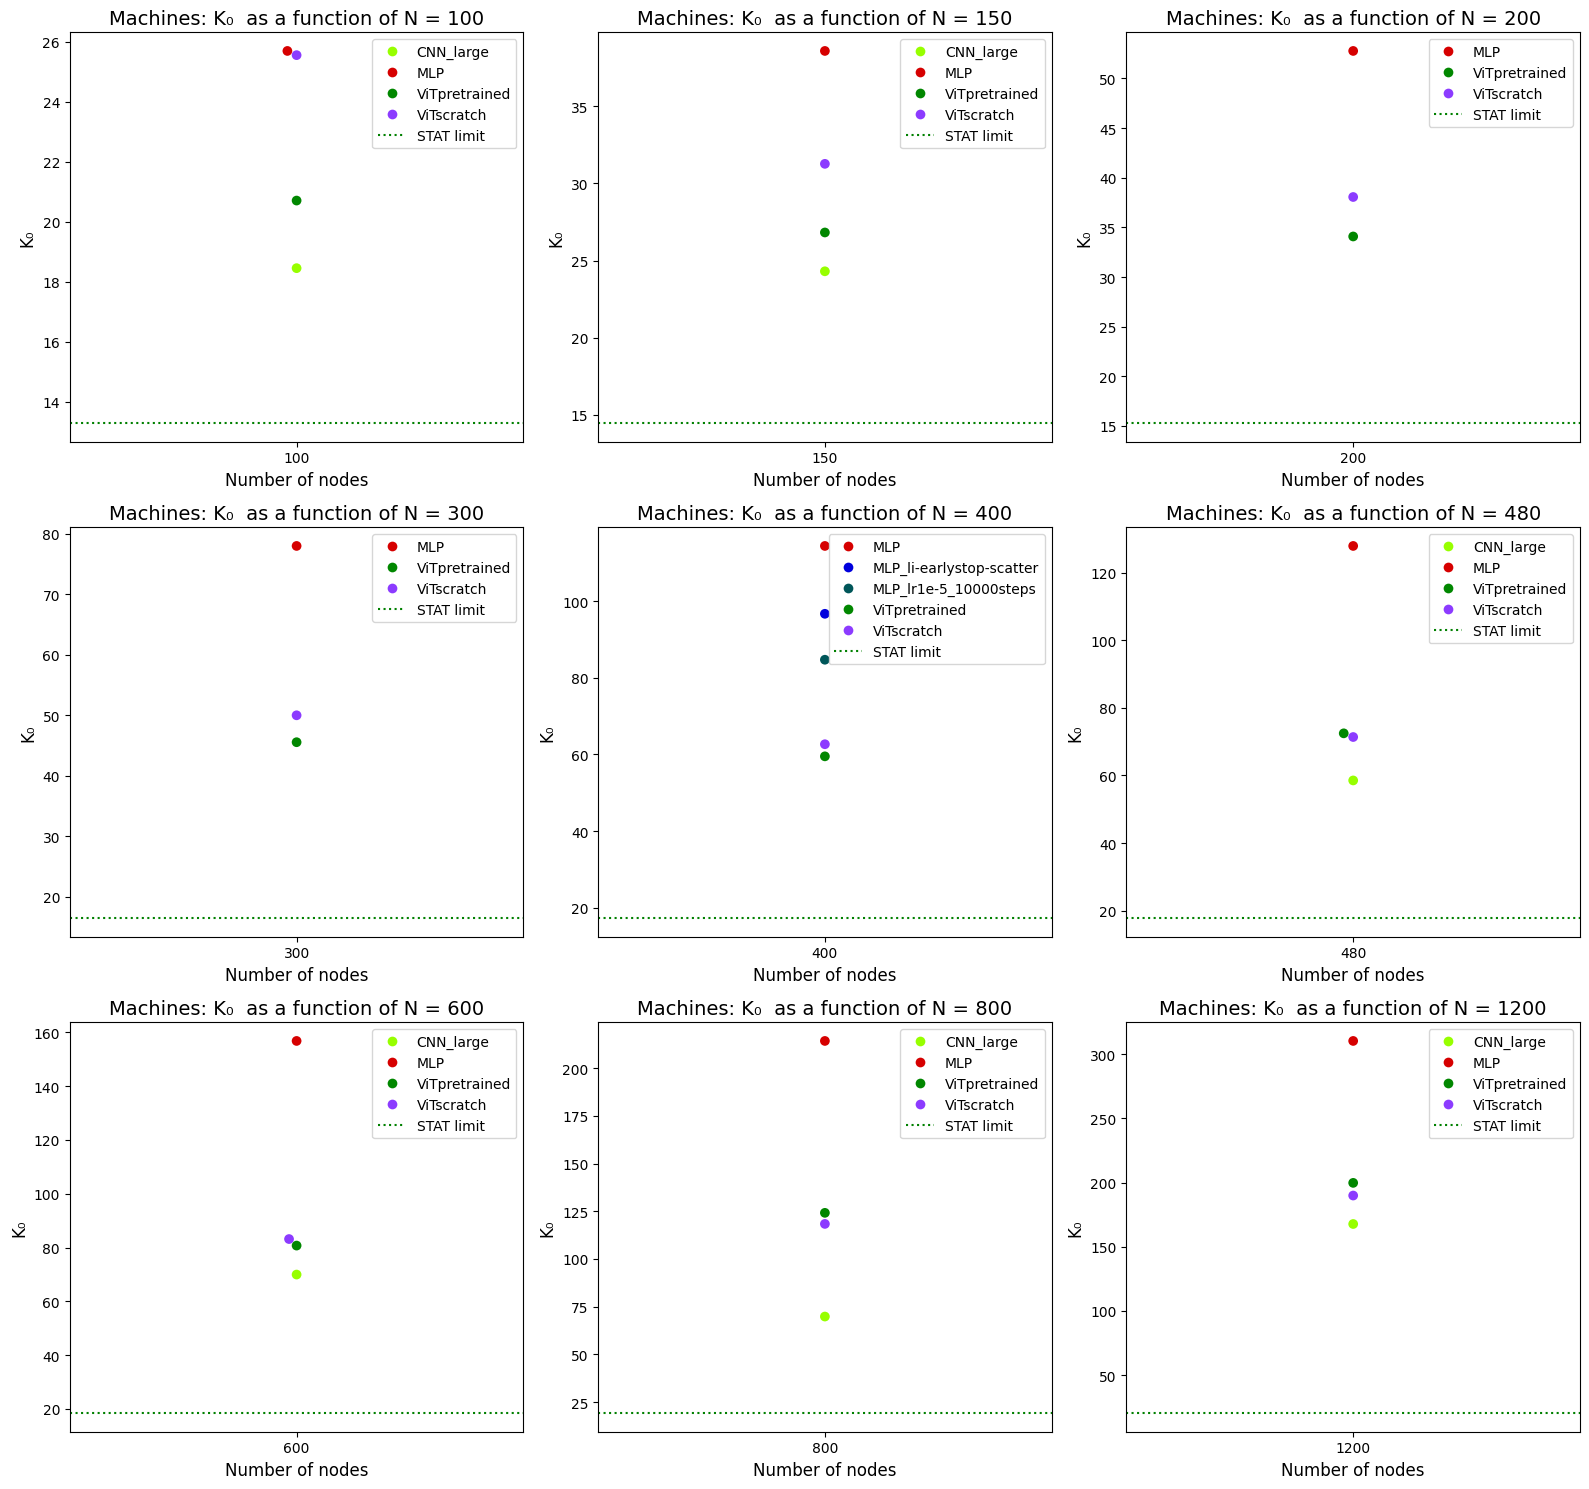

|Completed generating K0 plot.
|Generating main plot...


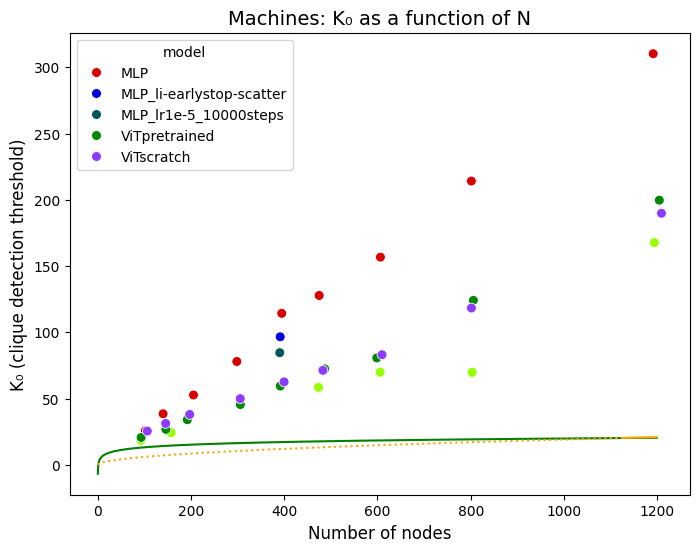

|Completed generating main plot.


In [25]:
# Instantiate the pipeline with the experiment name
exp_name = "2025-02-26_li-earlystop-scatter" # ADD EXPERIMENT NAME HERE
machines_pipeline = MachinesAnalysisPipeline(experiment_name=exp_name, variance_test=False, log_scale_K0=False)

# Run the entire pipeline
machines_pipeline.complete_machines_pipeline()

# Rudy's data:

This data has been given to us by Rudy, and is reported in the format he gave us at:

`C:\Users\danie\OneDrive - Università Campus Bio-Medico di Roma\Project-backup\HUPLACLIP - analysis\pilot_2_horizontal\Pilot2-combined-analysis.ipynb`

In [12]:
rudy_data = {
    "N": [300, 400, 500, 600, 700, 800, 900, 1000],
    "K0": [58.807378, 68.460279, 69.274007, 83.711061, 77.293921, 99.021618, 97.063763, 120.421003],
    "Delta": [33.296757, 32.858235, 25.201322, 32.531213, 27.540676, 43.135570, 32.509116, 58.510465],
}

# Create DataFrame
df_rudy_fitted_params = pd.DataFrame(rudy_data)

# Display the Dataframe:
df_rudy_fitted_params

,N,K0,Delta
0,300,58.807378,33.296757
1,400,68.460279,32.858235
2,500,69.274007,25.201322
3,600,83.711061,32.531213
4,700,77.293921,27.540676
5,800,99.021618,43.135570
6,900,97.063763,32.509116
7,1000,120.421003,58.510465


In [13]:
from scipy.stats import linregress

# fitting linearly K0 as a function of N and storing slope and intercept:
slope, intercept, r_value, p_value, std_err = linregress(df_rudy_fitted_params['N'], df_rudy_fitted_params['K0'])

# Combined plot:

In [ ]:
# Selecting the data to be used for the combined plot:
human_exp = "2023-06_thesis-data" # ADD EXPERIMENT NAME HERE
machines_exp = "2025-02-26_li-earlystop-scatter" # ADD EXPERIMENT NAME HERE

# Calling the pipelines to calculate the fitted parameters from the raw data:
# - humans
human_pipeline = HumanAnalysisPipeline(experiment_name=human_exp, analysis_type="subject-wise")
df_humans_fitted_params = human_pipeline.run_human_pipeline()
# - machines
machines_pipeline = MachinesAnalysisPipeline(experiment_name=machines_exp, variance_test=False, log_scale_K0=False)
df_machines_fitted_params, machines_palette = machines_pipeline.fitted_params_machines()


display(df_machines_fitted_params)
display(df_humans_fitted_params)

,model,N,K0,Delta
0,CNN_large,100,1.845103e+01,3.978695e+00
0,MLP,100,2.568927e+01,5.240386e+00
0,ViTpretrained,100,2.070365e+01,6.984122e+00
0,ViTscratch,100,2.554924e+01,6.502993e+00
0,CNN_large,1200,1.677221e+02,2.954822e+01
0,MLP,1200,3.102681e+02,6.208548e+01
0,ViTpretrained,1200,1.997479e+02,5.889966e+01
0,ViTscratch,1200,1.898838e+02,3.368262e+01
0,CNN_large,150,2.430369e+01,4.969536e+00
0,MLP,150,3.859321e+01,7.498055e+00


,subject_number,N,K0,Delta
0,1,1000.0,101.706023,77.307746
0,2,1000.0,117.000001,2.502066
0,3,1000.0,117.594153,43.151471
0,4,1000.0,92.021640,32.990984
0,5,1000.0,96.668492,28.820746
0,6,1000.0,120.846179,40.814821
0,7,1000.0,121.833296,43.931693
0,8,1000.0,116.711473,37.706514
0,9,1000.0,98.652622,39.415463
0,10,1000.0,54.591092,100.919698


C:\Users\danie\AppData\Local\Temp\ipykernel_12804\855489714.py:40: RuntimeWarning: divide by zero encountered in log2
  K_it = 2 * np.log2(N)


[<matplotlib.lines.Line2D object at 0x000001A7962916C0>, <matplotlib.lines.Line2D object at 0x000001A796291ED0>, <matplotlib.lines.Line2D object at 0x000001A796291A20>, <matplotlib.lines.Line2D object at 0x000001A7962906D0>, <matplotlib.lines.Line2D object at 0x000001A796291960>, <matplotlib.collections.PathCollection object at 0x000001A796293D60>, <matplotlib.lines.Line2D object at 0x000001A7962BCEE0>, <matplotlib.lines.Line2D object at 0x000001A7962BCE80>]
['MLP', 'MLP_li-earlystop-scatter', 'MLP_lr1e-5_10000steps', 'ViTpretrained', 'ViTscratch', 'Humans (mean)', 'STAT limit', 'COMP limit']
['CNN_large' 'MLP' 'MLP_li-earlystop-scatter' 'MLP_lr1e-5_10000steps'
 'ViTpretrained' 'ViTscratch']
['MLP', 'MLP_li-earlystop-scatter', 'MLP_lr1e-5_10000steps', 'ViTpretrained', 'ViTscratch']


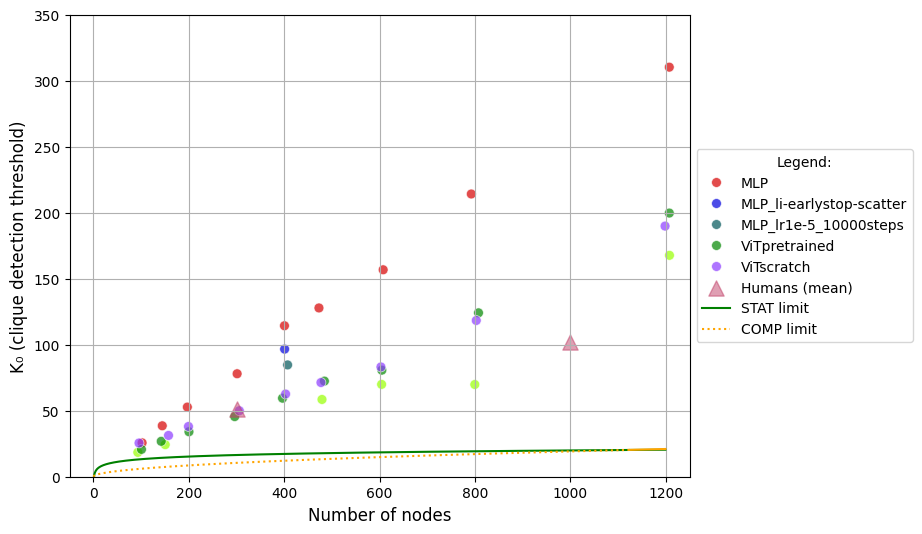

In [ ]:
# Create a smaller figure with specified size
fig, ax = plt.subplots(figsize=(8, 6))

# HUMAN DATA (pilot):
my_palette_human_subjects = sns.color_palette("flare", 15)
my_palette_human_mean = sns.color_palette("flare", 1)
# WITH SCATTERPLOT:
# ax_humans = sns.scatterplot(data=df_humans_fitted_params, x='N', y='K0', hue='subject_number', palette=my_palette_human_subjects, legend=False, alpha=0.4, s=70, marker="^")
# ax_humans.scatter(300, df_humans_fitted_params[df_humans_fitted_params['N'] == 300]['K0'].mean(), label='Humans (300)', color=my_palette_human_means[0], s=120, marker="^")
# ax_humans.scatter(1000, df_humans_fitted_params[df_humans_fitted_params['N'] == 1000]['K0'].mean(), label='Humans (1000)', color=my_palette_human_means[1], s=120, marker="^")
# WIHTOUT SCATTERPLOT:
ax.scatter(300, df_humans_fitted_params[df_humans_fitted_params['N'] == 300]['K0'].mean(), label='Humans (mean)', color=my_palette_human_mean, s=120, marker="^", alpha=0.5)
ax.scatter(1000, df_humans_fitted_params[df_humans_fitted_params['N'] == 1000]['K0'].mean(), color=my_palette_human_mean, s=120, marker="^", alpha=0.5)

# MACHINES DATA:
# Loop through the N values:
for i, N_value in enumerate(df_machines_fitted_params['N'].unique()):
    # Isolating data for the current N value:
    current_fitted_params = df_machines_fitted_params[df_machines_fitted_params['N'] == N_value]
    # Filtering the data to keep only the models for which K0 is smaller than N:
    current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
    # Filtering the palette
    machines_palette_filtered = {key: machines_palette[key] for key in current_fitted_params['model'].unique()}
    
    # Add a small jitter to the N column to avoid overlap
    jittered_x = current_fitted_params['N'] + np.random.uniform(-8, 8, size=len(current_fitted_params))
    
    # Draw scatterplot with jittered x values (only drawing one legend)
    # TO FIX: NOW THE LEGEND CONTAINS ALL MLP VARIANTS BUT DOES NOT CONTAIN CNN_large
    sns.scatterplot(data=current_fitted_params, x=jittered_x, y='K0', hue='model', 
                    palette=machines_palette_filtered, legend=(N_value == 400), s=50, ax=ax, alpha=0.7) # Only draw legend for N=400 (contains MLP variants)

# RUDY'S DATA:
#sns.scatterplot(data=df_rudy_fitted_params, x='N', y='K0', label='CNN-rudy', color='orange', s=70, marker='s', alpha=0.5, ax=ax)
    
# THEORETICAL AND COMPUTATIONAL LIMITS:
N = np.arange(0, 1200)
K_it = 2 * np.log2(N)
K_comp = np.sqrt(N / np.e)
limits_palette = ['green', 'orange']
ax.plot(N, K_it, label='STAT limit', color=limits_palette[0])
ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
ax.plot(N[1125:], K_comp[1125:], color=limits_palette[1])

# Add axes labels to the plot
ax.set_xlabel('Number of nodes', size=12)
ax.set_ylabel('K₀ (clique detection threshold)', size=12)

# Drawing linear fit of Rudy's datapoints color gradient
# y_values = slope * N + intercept
# ax.plot(N, y_values, color=my_palette_rudy[1], linestyle='--')

# Ensure x-axis limits cover the necessary range
ax.set_xlim(-50, 1250)
ax.set_ylim(0, 350) # without variance test
# ax.set_ylim(0, 900) # with variance test

# Customize legend:
handles, labels = ax.get_legend_handles_labels()

# TO FIX: after this, the legend does not contain the CNN_large model (not present at N=400 -> choose another N value once the data is chosen)
print(handles)
print(labels)

filtered_handles = []
filtered_labels = []

# List of labels you want to keep in the legend
labels_to_keep = np.unique(df_machines_fitted_params['model'].values)
print(labels_to_keep)

for handle, label in zip(handles, labels):
    if label in labels_to_keep or label in ['CNN_large']:
        filtered_handles.append(handle)
        filtered_labels.append(label)
print(filtered_labels)        

# Add a custom legend with only the desired elements
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Legend:')

plt.grid()

# Save plot as high resolution svg:
# - Without variance test
plt.savefig(f'./plots/{exp_name}/comparison-graph_{exp_name}.svg', dpi=300, bbox_inches="tight")
plt.savefig(f'./plots/{exp_name}/comparison-graph_{exp_name}.png', dpi=300, bbox_inches="tight")
# - With variance test
# plt.savefig(f'./plots/{exp_name}/comparison-graph_{exp_name}_Variance-test.svg', dpi=300, bbox_inches="tight")
# plt.savefig(f'./plots/{exp_name}/comparison-graph_{exp_name}_Variance-test.png', dpi=300, bbox_inches="tight")

plt.show()
